In [ ]:
from __future__ import print_function
import numpy
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.bn1=torch.nn.BatchNorm2d(20)
        self.w1_1 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.w2_1 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.w3_1 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.bn2=torch.nn.BatchNorm2d(50)
        self.w1_2 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.w2_2 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.w3_2 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.bn3=torch.nn.BatchNorm1d(500)
        self.w1_3 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.w2_3 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.w3_3 = torch.nn.Parameter(data=torch.abs(torch.randn (1)), requires_grad=True)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = ((self.bn1(self.conv1(x))))
        self.w1_1.data=self.w1_1.data.clamp(min=0)
        self.w2_1.data=self.w2_1.data.clamp(min=0)
        self.w3_1.data=self.w3_1.data.clamp(min=0)
        self.w1_2.data=self.w1_2.data.clamp(min=0)
        self.w2_2.data=self.w2_2.data.clamp(min=0)
        self.w3_2.data=self.w3_2.data.clamp(min=0)
        self.w1_3.data=self.w1_3.data.clamp(min=0)
        self.w2_3.data=self.w2_3.data.clamp(min=0)
        self.w3_3.data=self.w3_3.data.clamp(min=0)
        x =(self.w1_1*F.relu(x)+self.w2_1*F.tanh(x)+self.w3_1*torch.sin(x))/(self.w1_1+self.w2_1+self.w3_1+1e-5)
        x = F.max_pool2d(x, 2, 2)
        x = ((self.bn2(self.conv2(x))))
        x =(self.w1_2*F.relu(x)+self.w2_2*F.tanh(x)+self.w3_2*torch.sin(x))/(self.w1_2+self.w2_2+self.w3_2+1e-5)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x =(self.bn3(self.fc1(x)))
        x =(self.w1_3*F.relu(x)+self.w2_3*F.tanh(x)+self.w3_3*torch.sin(x))/(self.w1_3+self.w2_3+self.w3_3+1e-5)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [ ]:
n_epochs = 30
batch_size_train = 64
batch_size_test = 1000
learning_rate =1e-4
momentum = 0.5
log_interval = 200

In [ ]:
# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/d/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/d/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /d/MNIST/raw/train-images-idx3-ubyte.gz to /d/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /d/MNIST/raw/train-labels-idx1-ubyte.gz to /d/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /d/MNIST/raw/t10k-images-idx3-ubyte.gz to /d/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /d/MNIST/raw/t10k-labels-idx1-ubyte.gz to /d/MNIST/raw



In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1000, 1, 28, 28])

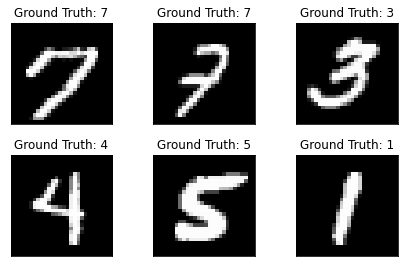

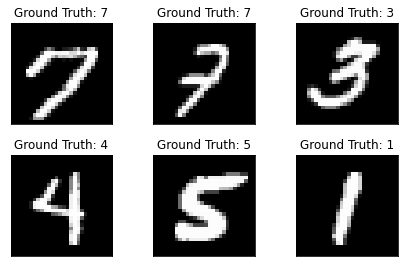

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
network = Net()


In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
network.cuda()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data=data.cuda()
    target=target.cuda()
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.cuda()
      target=target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(
        (batch_idx*64) + ((epoch-1)*len(test_loader.dataset)))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  print(network.w1_1/(network.w1_1+network.w2_1+network.w3_1))
  print(network.w2_1/(network.w1_1+network.w2_1+network.w3_1))
  print(network.w3_1/(network.w1_1+network.w2_1+network.w3_1))
  print(network.w1_2/(network.w1_2+network.w2_2+network.w3_2))
  print(network.w2_2/(network.w1_2+network.w2_2+network.w3_2))
  print(network.w3_2/(network.w1_2+network.w2_2+network.w3_2))

In [ ]:
optimizer = torch.optim.Adam(
    [
        {"params": network.conv1.parameters(), "lr": 1e-3},
        {"params": network.conv2.parameters(), "lr": 1e-3},
        {"params": network.bn1.parameters(), "lr": 1e-3},
        {"params": network.bn2.parameters(), "lr": 1e-3},
        {"params": network.bn3.parameters(), "lr": 1e-3},
        {"params": network.fc1.parameters(), "lr": 1e-3},
        {"params": network.fc2.parameters(), "lr": 1e-3},
        {"params": network.w1_1},
        {"params": network.w2_1},
        {"params": network.w3_1},
        {"params": network.w1_2},
        {"params": network.w2_2},
        {"params": network.w3_2},
        {"params": network.w1_3},
        {"params": network.w2_3},
        {"params": network.w3_3},
        
    ],
    lr=0,
)
for epoch in range(1, 10 + 1):
  train(epoch)
  test()
optimizer = torch.optim.Adam(
    [
        {"params": network.conv1.parameters(), "lr": 0},
        {"params": network.conv2.parameters(), "lr": 0},
        {"params": network.bn1.parameters(), "lr":0},
        {"params": network.bn2.parameters(), "lr": 0},
        {"params": network.bn3.parameters(), "lr": 0},
        {"params": network.fc1.parameters(), "lr": 0},
        {"params": network.fc2.parameters(), "lr": 0},
        {"params": network.w1_1},
        {"params": network.w2_1},
        {"params": network.w3_1},
        {"params": network.w1_2},
        {"params": network.w2_2},
        {"params": network.w3_2},
        {"params": network.w1_3},
        {"params": network.w2_3},
        {"params": network.w3_3},
        
    ],
    lr=1e-2,
)
for epoch in range(1, 20 + 1):
  train(epoch)
  test()
optimizer = torch.optim.Adam(
    [
        {"params": network.conv1.parameters(), "lr": 1e-3},
        {"params": network.conv2.parameters(), "lr": 1e-3},
        {"params": network.bn1.parameters(), "lr": 1e-3},
        {"params": network.bn2.parameters(), "lr": 1e-3},
        {"params": network.bn3.parameters(), "lr": 1e-3},
        {"params": network.fc1.parameters(), "lr": 1e-3},
        {"params": network.fc2.parameters(), "lr": 1e-3},
        {"params": network.w1_1, "lr": 0},
        {"params": network.w2_1, "lr": 0},
        {"params": network.w3_1, "lr": 0},
        {"params": network.w1_2, "lr": 0},
        {"params": network.w2_2, "lr": 0},
        {"params": network.w3_2, "lr": 0},
        {"params": network.w1_3, "lr": 0},
        {"params": network.w2_3, "lr": 0},
        {"params": network.w3_3, "lr": 0},
        
    ],
    lr=1e-4,
)
for epoch in range(1, 10 + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.465106
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.093459
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.135357
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.074514
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.009288


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0369, Accuracy: 9897/10000 (99%)

tensor([0.4915], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.3965], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.1120], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.0266], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.7190], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.2543], device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.103846
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.005366
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.092259
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.049374
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.018978

Test set: Avg. loss: 0.0378, Accuracy: 9889/10000 (99%)

tensor([0.4915], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.3965], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.1120], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.0266], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.7190], device='cuda:0', grad_fn=<DivBackward0>)
t

In [ ]:
torch.save(network, 'MNIST.pth')

In [ ]:


network = torch.load('MNIST.pth')
network.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


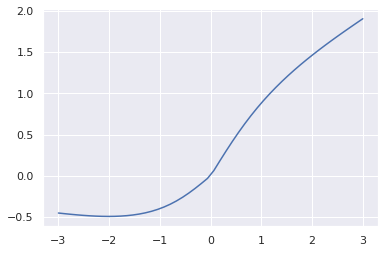

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


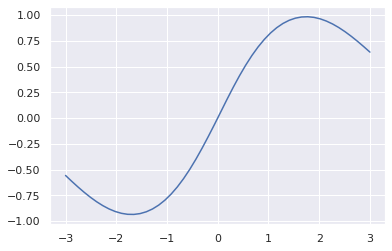

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


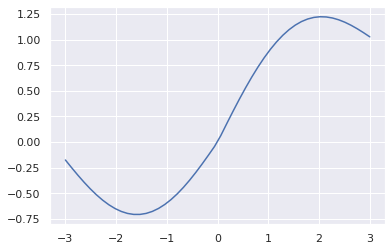

In [ ]:
network.cpu()
import seaborn as sns
sns.set()
x = torch.Tensor(np.linspace(-3, 3))
plt.plot(x.cpu().detach().numpy(),(network.w1_1*F.relu(x)+network.w2_1*F.tanh(x)+network.w3_1*torch.sin(x)).detach().numpy()/(network.w1_1+network.w2_1+network.w3_1+1e-5).cpu().detach().numpy())
#plt.yscale('log')
plt.show()
plt.plot(x.cpu().detach().numpy(),(network.w1_2*F.relu(x)+network.w2_2*F.tanh(x)+network.w3_2*torch.sin(x)).detach().numpy()/(network.w1_2+network.w2_2+network.w3_2+1e-5).cpu().detach().numpy())
plt.show()
plt.plot(x.cpu().detach().numpy(),(network.w1_3*F.relu(x)+network.w2_3*F.tanh(x)+network.w3_3*torch.sin(x)).detach().numpy()/(network.w1_3+network.w2_3+network.w3_3+1e-5).cpu().detach().numpy())
plt.show()



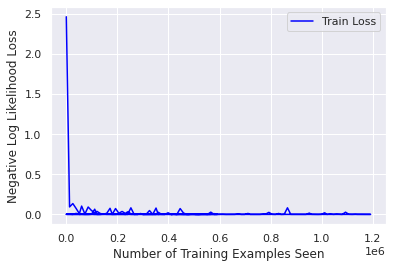

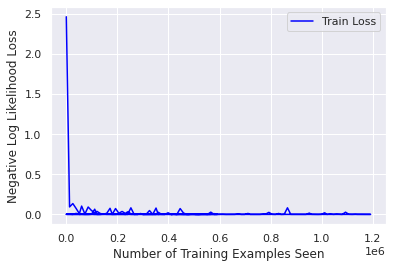

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')

train_losses1=train_losses
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Number of Training Examples Seen')
plt.ylabel('Negative Log Likelihood Loss')
fig

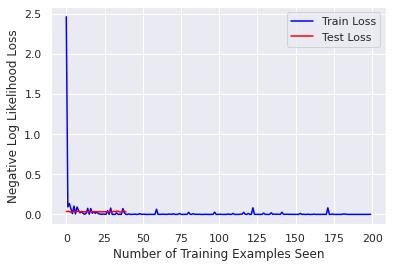

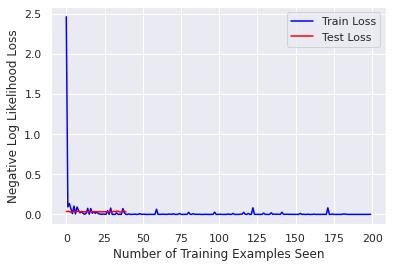

In [ ]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.plot( test_losses, color='red')
train_losses1=train_losses
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Number of Training Examples Seen')
plt.ylabel('Negative Log Likelihood Loss')
fig

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


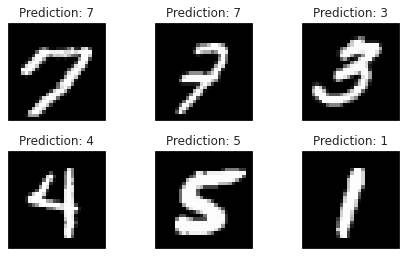

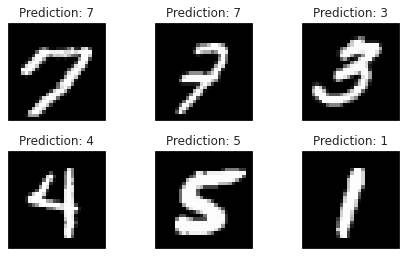

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
network

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


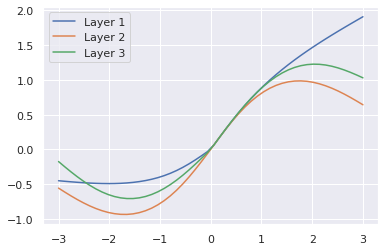

In [ ]:
x = torch.Tensor(np.linspace(-3, 3))
plt.plot(x.cpu().detach().numpy(),(network.w1_1*F.relu(x)+network.w2_1*F.tanh(x)+network.w3_1*torch.sin(x)).detach().numpy()/(network.w1_1+network.w2_1+network.w3_1+1e-5).cpu().detach().numpy(),label='Layer 1')
plt.plot(x.cpu().detach().numpy(),(network.w1_2*F.relu(x)+network.w2_2*F.tanh(x)+network.w3_2*torch.sin(x)).detach().numpy()/(network.w1_2+network.w2_2+network.w3_2+1e-5).cpu().detach().numpy(),label='Layer 2')
plt.plot(x.cpu().detach().numpy(),(network.w1_3*F.relu(x)+network.w2_3*F.tanh(x)+network.w3_3*torch.sin(x)).detach().numpy()/(network.w1_3+network.w2_3+network.w3_3+1e-5).cpu().detach().numpy(),label='Layer 3')
plt.legend(ncol=1, loc='upper left');
plt.show()


In [ ]:
  print(network.w1_1/(network.w1_1+network.w2_1+network.w3_1))
  print(network.w2_1/(network.w1_1+network.w2_1+network.w3_1))
  print(network.w3_1/(network.w1_1+network.w2_1+network.w3_1))
  print(network.w1_2/(network.w1_2+network.w2_2+network.w3_2))
  print(network.w2_2/(network.w1_2+network.w2_2+network.w3_2))
  print(network.w3_2/(network.w1_2+network.w2_2+network.w3_2))
  print(network.w1_3/(network.w1_3+network.w2_3+network.w3_3))
  print(network.w2_3/(network.w1_3+network.w2_3+network.w3_3))
  print(network.w3_3/(network.w1_3+network.w2_3+network.w3_3))

tensor([0.4848], grad_fn=<DivBackward0>)
tensor([0.4437], grad_fn=<DivBackward0>)
tensor([0.0715], grad_fn=<DivBackward0>)
tensor([0.0276], grad_fn=<DivBackward0>)
tensor([0.4923], grad_fn=<DivBackward0>)
tensor([0.4800], grad_fn=<DivBackward0>)
tensor([0.2840], grad_fn=<DivBackward0>)
tensor([0.0877], grad_fn=<DivBackward0>)
tensor([0.6283], grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


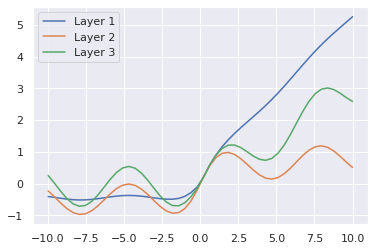

In [ ]:
x = torch.Tensor(np.linspace(-10, 10))
plt.plot(x.cpu().detach().numpy(),(network.w1_1*F.relu(x)+network.w2_1*F.tanh(x)+network.w3_1*torch.sin(x)).detach().numpy()/(network.w1_1+network.w2_1+network.w3_1+1e-5).cpu().detach().numpy(),label='Layer 1')
plt.plot(x.cpu().detach().numpy(),(network.w1_2*F.relu(x)+network.w2_2*F.tanh(x)+network.w3_2*torch.sin(x)).detach().numpy()/(network.w1_2+network.w2_2+network.w3_2+1e-5).cpu().detach().numpy(),label='Layer 2')
plt.plot(x.cpu().detach().numpy(),(network.w1_3*F.relu(x)+network.w2_3*F.tanh(x)+network.w3_3*torch.sin(x)).detach().numpy()/(network.w1_3+network.w2_3+network.w3_3+1e-5).cpu().detach().numpy(),label='Layer 3')
plt.legend(ncol=1, loc='upper left');
plt.show()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


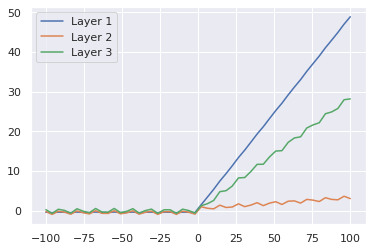

In [ ]:
x = torch.Tensor(np.linspace(-100, 100))
plt.plot(x.cpu().detach().numpy(),(network.w1_1*F.relu(x)+network.w2_1*F.tanh(x)+network.w3_1*torch.sin(x)).detach().numpy()/(network.w1_1+network.w2_1+network.w3_1+1e-5).cpu().detach().numpy(),label='Layer 1')
plt.plot(x.cpu().detach().numpy(),(network.w1_2*F.relu(x)+network.w2_2*F.tanh(x)+network.w3_2*torch.sin(x)).detach().numpy()/(network.w1_2+network.w2_2+network.w3_2+1e-5).cpu().detach().numpy(),label='Layer 2')
plt.plot(x.cpu().detach().numpy(),(network.w1_3*F.relu(x)+network.w2_3*F.tanh(x)+network.w3_3*torch.sin(x)).detach().numpy()/(network.w1_3+network.w2_3+network.w3_3+1e-5).cpu().detach().numpy(),label='Layer 3')
plt.legend(ncol=1, loc='upper left');
plt.show()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


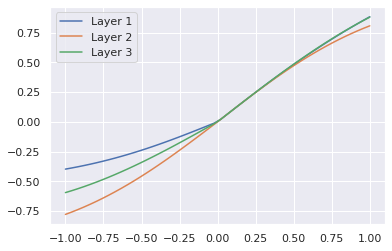

In [ ]:
x = torch.Tensor(np.linspace(-1, 1))
plt.plot(x.cpu().detach().numpy(),(network.w1_1*F.relu(x)+network.w2_1*F.tanh(x)+network.w3_1*torch.sin(x)).detach().numpy()/(network.w1_1+network.w2_1+network.w3_1+1e-5).cpu().detach().numpy(),label='Layer 1')
plt.plot(x.cpu().detach().numpy(),(network.w1_2*F.relu(x)+network.w2_2*F.tanh(x)+network.w3_2*torch.sin(x)).detach().numpy()/(network.w1_2+network.w2_2+network.w3_2+1e-5).cpu().detach().numpy(),label='Layer 2')
plt.plot(x.cpu().detach().numpy(),(network.w1_3*F.relu(x)+network.w2_3*F.tanh(x)+network.w3_3*torch.sin(x)).detach().numpy()/(network.w1_3+network.w2_3+network.w3_3+1e-5).cpu().detach().numpy(),label='Layer 3')
plt.legend(ncol=1, loc='upper left');
plt.show()